In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openml.datasets import get_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from causalml.inference.meta import BaseTRegressor
from xgboost import XGBRegressor
import shap

## Load Dataset and Prepare Features for Causal Inference

In [2]:
dataset = get_dataset(1472)
df, _, _, _ = dataset.get_data()

In [3]:
df.columns = [
    'Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
    'Overall Height', 'Orientation', 'Glazing Area',
    'Glazing Area Distribution', 'Heating Load', 'Cooling Load'
]

## Split Data into Train and Test Sets

In [4]:
y = df['Heating Load']

# Treatment: buildings with higher-than-median Roof Area
df['treatment'] = (df['Roof Area'] > df['Roof Area'].median()).astype(int)

# Features (exclude target, treatment, and Roof Area to avoid leakage)
features = df.drop(columns=['Heating Load', 'Cooling Load', 'Roof Area', 'treatment'])
T = df['treatment']

In [5]:
y = pd.to_numeric(df['Heating Load'], errors='coerce')

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [7]:
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X_scaled, T.values, y.values, test_size=0.3, random_state=42
)

## Train Linear Double Machine Learning (DML) Estimator

In [8]:
dml = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0),
    model_t=GradientBoostingClassifier(n_estimators=100, random_state=0),
    discrete_treatment=True,
    random_state=0
)

In [9]:
dml.fit(Y=y_train, T=T_train, X=X_train)
te_dml = dml.effect(X_test)
ate_dml = np.mean(te_dml)

## Estimate Treatment Effects using CausalML (T-Learner)

In [10]:
cf = BaseTRegressor(learner=XGBRegressor(), control_name=0)
cf.fit(X=X_train, treatment=T_train, y=y_train)

In [11]:
te_cf = cf.predict(X_test)        
ate_cf = np.mean(te_cf)            

## Visualize Treatment Effects (DML vs CausalML)

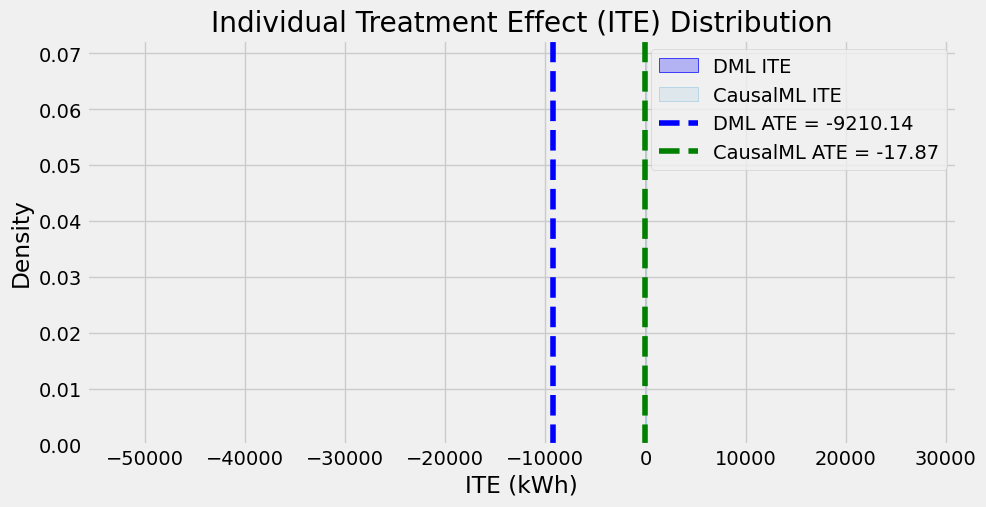

In [12]:
plt.figure(figsize=(10, 5))
sns.kdeplot(te_dml, label='DML ITE', fill=True, color='blue')
sns.kdeplot(te_cf, label='CausalML ITE', fill=True, color='green')
plt.axvline(ate_dml, color='blue', linestyle='--', label=f'DML ATE = {ate_dml:.2f}')
plt.axvline(ate_cf, color='green', linestyle='--', label=f'CausalML ATE = {ate_cf:.2f}')
plt.title("Individual Treatment Effect (ITE) Distribution")
plt.xlabel("ITE (kWh)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


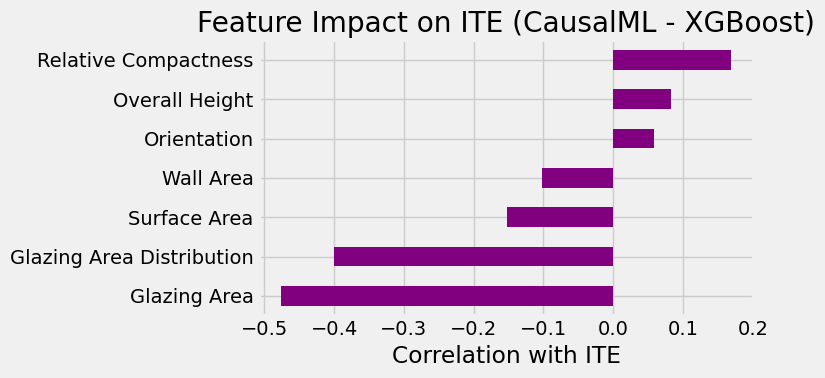

In [13]:
df_feat = pd.DataFrame(X_test, columns=features.columns)
df_feat['ITE_CF'] = te_cf

correlations = df_feat.corr()['ITE_CF'].drop('ITE_CF').sort_values()

plt.figure(figsize=(8, 4))
correlations.plot(kind='barh', color='purple')
plt.title("Feature Impact on ITE (CausalML - XGBoost)")
plt.xlabel("Correlation with ITE")
plt.tight_layout()
plt.show()


## Explain Feature Importance with SHAP (on model_y in DML)

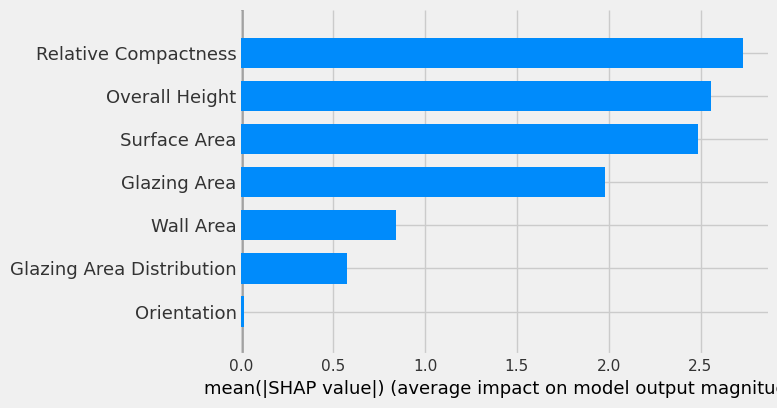

In [14]:
fitted_model = dml.models_y[0][0]
explainer = shap.TreeExplainer(fitted_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features.columns, plot_type="bar")

In [15]:
print("Final ATE Estimates:")
print(f"Double ML ATE: {ate_dml:.2f} kWh")
print(f"CausalML (T-Learner) ATE: {ate_cf:.2f} kWh")


Final ATE Estimates:
Double ML ATE: -9210.14 kWh
CausalML (T-Learner) ATE: -17.87 kWh
